In [1]:
%matplotlib inline

import os
from collections import Counter
from itertools import count
from scipy.stats import gaussian_kde
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import gaussian_kde
from srim.srim import SRIM
from srim.core.target import Target
from srim.core.layer import Layer
from srim.core.ion import Ion
from srim.core.element import Element
from srim.output import (
    Results, Phonons, Ioniz, Vacancy, 
    NoVacancy, EnergyToRecoils, Range,
    Collision
)
import seaborn
from pathlib import Path

# C, O, Si, Ni and Au in SiC 

Here are the detail requirements for the calculations and plots:

 - Ions:  4.5 MeV C, 6.5 MeV O, 21 MeV Si, 21 MeV Ni, and 25 MeV Au
 - Target: SiC, density of SiC is 3.21 g cm-3. The threshold displacement energy is taken to be 35 and 20 eV for Si and C sublattice, respectively.
 - Plots: ideally 3 plots for each ion-SiC combination (XY plane, XZ plane and YZ plane) from 0 to 1000 nm. It may also work for the purpose in the manuscript if you can plot for a narrower depth, for example from 450 nm to 550 nm.
 - No need to plot anything deeper than 1000 nm.

Please try to plot the cases for 21 MeV Si and 25 MeV Au, and send me to have a look (so we can finalize) before spending too much time.

In [2]:
# Define calculations in code
ions = [
    {'identifier': 'Au', 'energy': 25.0e6}, # eV
#    {'identifier': 'C', 'energy': 4.5e6}, # eV
#    {'identifier': 'O', 'energy': 6.5e6}, # eV
#    {'identifier': 'Si', 'energy': 21.0e6}, # eV
#    {'identifier': 'Ni', 'energy': 21.0e6}, # eV
]

layer = Layer({
    'Si': {
        'stoich': 0.5,
        'E_d': 35.0, # Displacement Energy
        'lattice': 0.0,
        'surface': 3.0
    },
    'C': {
        'stoich': 0.5,
        'E_d': 20.0, # Displacement Energy
        'lattice': 0.0,
        'surface': 3.0
    }
}, density=3.21, width=10000.0)
target = Target([layer])

In [3]:
# Helper functions to run calculations
def fragment(step, total):
    remaining = total
    while remaining > 0:
        if step > remaining:
            return remaining
        else:
            remaining -= step
            yield step
            
def find_folder(directory):
    for i in count():
        path = Path(directory) / str(i)
        if not path.is_dir():
            return str(path.absolute())

def run_fragmented_calculation(ion, target, number_ions, path, calculation=2, step=1000):
    for i, num_ions in enumerate(fragment(step, number_ions)):
        print('%d\t%s\t%d' % (i, ion.symbol, num_ions))
        srim = SRIM(target, ion, number_ions=num_ions, calculation=calculation, collisions=2, random_seed=randint(0, 100000))
        results = srim.run('/tmp/srim')
        save_directory = find_folder(path)
        print(save_directory)
        os.makedirs(save_directory, exist_ok=True)
        SRIM.copy_output_files('/tmp/srim', save_directory)

In [ ]:
# Run SRIM calcluations for each ion
step = 1e3
num_ions = 1e4

for ion in ions:
    symbol_path = os.path.join('/home/costrouc/dev/materials/srim-calculation/data', ion['identifier'])
    run_fragmented_calculation(Ion(**ion), target, num_ions, symbol_path, step=step)

0	Au	1000


# Analysis
 - Read Collisions.txt
 - Plot heatmap of yz plane
 - Radial distribution of yz plane about center (0, 0)

In [2]:
# Helper functions
def parse_directory(dir):
    if not os.path.exists('./%s/collision.dat.npy' % dir):
        positions = []
        with open('./%s/COLLISON.txt' % dir, 'rb') as f:
            for line in f.readlines():
                line = line.decode('latin-1')
                if line.endswith('Start of New Cascade  ³\r\n'):
                    tokens = line.split(chr(179))[1:-1]
                    positions.append([float(tokens[2]), float(tokens[3]), float(tokens[4])])
                elif line.startswith('Û 0'):
                    tokens = line.split()[1:-1]
                    positions.append([float(tokens[3]), float(tokens[4]), float(tokens[5])])
        np.save('./%s/collision.dat' % dir, np.array(positions))

def plot_heatmap(ax, data, cols, limits, norm):
    c1, c2 = cols
    (c1min, c1max), (c2min, c2max) = limits
    region_data = data[(data[:, c1] < c1max) & (data[:, c1] > c1min) & (data[:, c2] < c2max) & (data[:, c2] > c2min)]
    heatmap, xedges, yedges = np.histogram2d(region_data[:, c1], region_data[:, c2], range=limits, bins=(1000, 200))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    heatmap[heatmap == 0.0] = np.nan
    colormap = mpl.cm.get_cmap('viridis')
    return ax.imshow(heatmap.T, origin='lower', extent=extent, cmap=colormap, norm=norm)
    
def plot_radial_distribution_hist(ax, data, maximum, label):
    density, edges = np.histogram(data, bins=100, density=False, range=(1e-8, maximum))
    x = np.linspace(1e-8, maximum, len(density))
    # return ax.plot(x, density, label=label)
    return ax.semilogy(x, density, label=label)
    
def plot_radial_distribution_kde(ax, data, maximum, label):
    x = np.linspace(0, maximum, 100)
    kde = gaussian_kde(np.concatenate((-data, data)))
    return ax.plot(x, kde.pdf(x), label=label)
    
sort_by_mass = lambda e1: Element(e1).mass

In [3]:
os.chdir('/home/costrouc/dev/materials/yanwen-SiC/data/')

In [4]:
# Read all SRIM Calculations
os.chdir('/home/costrouc/dev/materials/yanwen-SiC/data/')

for dir in os.listdir():
    calculation_data = []
    total_ions = 0
    for calculation in os.listdir(dir):
        parse_directory(os.path.join(dir, calculation))

In [5]:
os.chdir('/home/costrouc/dev/materials/yanwen-SiC/data/')

data = {}
for dir in os.listdir():
    collisions = []
    total_ions = 0
    for calculation in os.listdir(dir):
        with open('./%s/%s/TRIM.IN' % (dir, calculation)) as f:
            num_ions = int(f.read().split('\n')[2].split()[-3])
        total_ions += num_ions
        collisions.append(np.load('./%s/%s/collision.dat.npy' % (dir, calculation)))
    data[dir] = {'total_ions': total_ions, 'collisions': np.concatenate(collisions) / 10}

In [6]:
for ion in sorted(data, key=sort_by_mass):
    data_str = (
        "Symbol: {:2}\tNum Ions: {:7d}\tCollisions: {:7d}\n"
        "|\tMedian (x, y, z) [nm]: [{:.3f}\t{:.3f}\t{:.3f}]\n"
        "|\tMean   (x, y, z) [nm]: [{:.3f}\t{:.3f}\t{:.3f}]\n"
    )
    print(data_str.format(ion, data[ion]['total_ions'], len(data[ion]['collisions']), 
                          *np.median(data[ion]['collisions'], axis=0),
                          *np.mean(data[ion]['collisions'], axis=0)))

Symbol: C 	Num Ions:   10000	Collisions:  573511
|	Median (x, y, z) [nm]: [574.800	-0.034	0.004]
|	Mean   (x, y, z) [nm]: [550.093	-2.349	4.141]

Symbol: O 	Num Ions:   10000	Collisions:  859243
|	Median (x, y, z) [nm]: [558.600	-0.014	0.001]
|	Mean   (x, y, z) [nm]: [542.428	2.455	1.537]

Symbol: Si	Num Ions:   10000	Collisions: 1190005
|	Median (x, y, z) [nm]: [531.700	-0.005	0.005]
|	Mean   (x, y, z) [nm]: [524.983	-3.016	0.385]

Symbol: Ni	Num Ions:   10000	Collisions: 7385004
|	Median (x, y, z) [nm]: [553.200	0.002	0.005]
|	Mean   (x, y, z) [nm]: [535.741	-1.346	0.920]



/home/costrouc/dev/materials/yanwen-SiC/venv/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


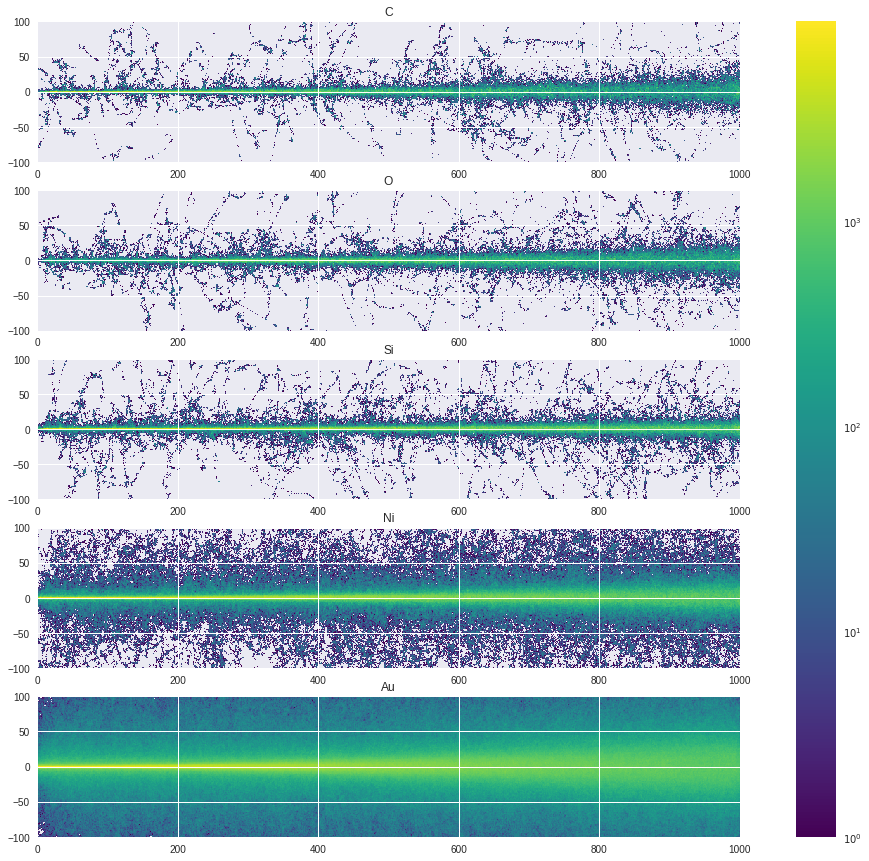

In [34]:
# Using Log color scale
limits = [[0, 1000], [-100, 100]]

fig, axes = plt.subplots(5, 1)
for ax, ion in zip(axes.flat, sorted(data, key=sort_by_mass)):
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (0, 2), limits, norm)
    ax.set_title(ion)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.set_size_inches(20, 15)
fig.savefig('../images/length-heatmap-log.png', transparent=False, dpi=300)

/home/costrouc/dev/materials/yanwen-SiC/venv/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


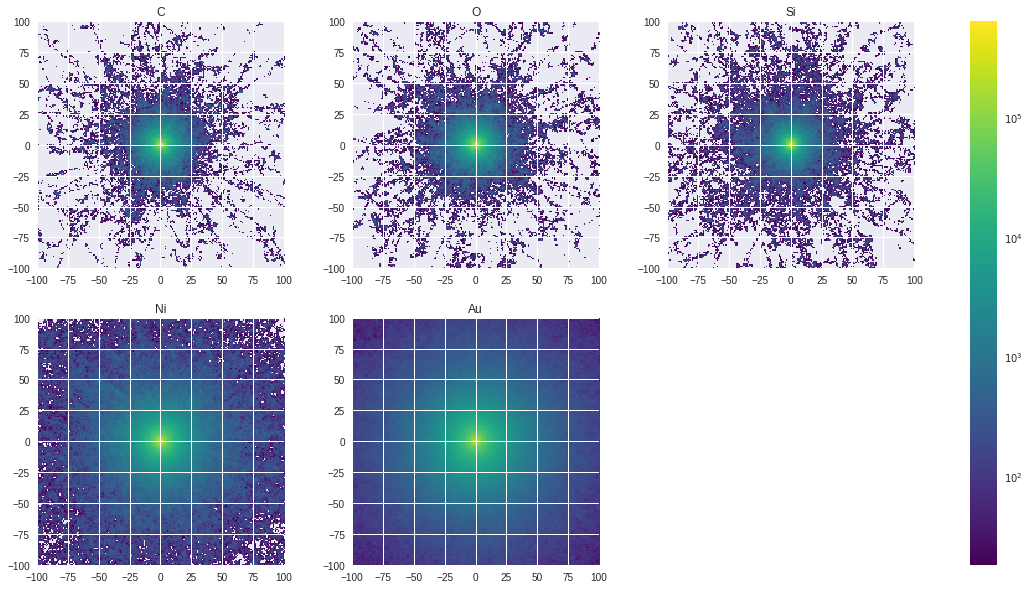

In [30]:
# Using Log color scale
limits = [[-100, 100], [-100, 100]]

fig, axes = plt.subplots(2, 3)
for ax, ion in zip(axes.flat, sorted(data, key=sort_by_mass)):
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (1, 2), limits, norm)
    ax.set_title(ion)
fig.delaxes(axes[1][2])
fig.colorbar(im, ax=axes.ravel().tolist())
fig.set_size_inches(20, 10)
fig.savefig('../images/radial-heatmap-log.png', transparent=False, dpi=300)

/home/costrouc/dev/materials/yanwen-SiC/venv/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


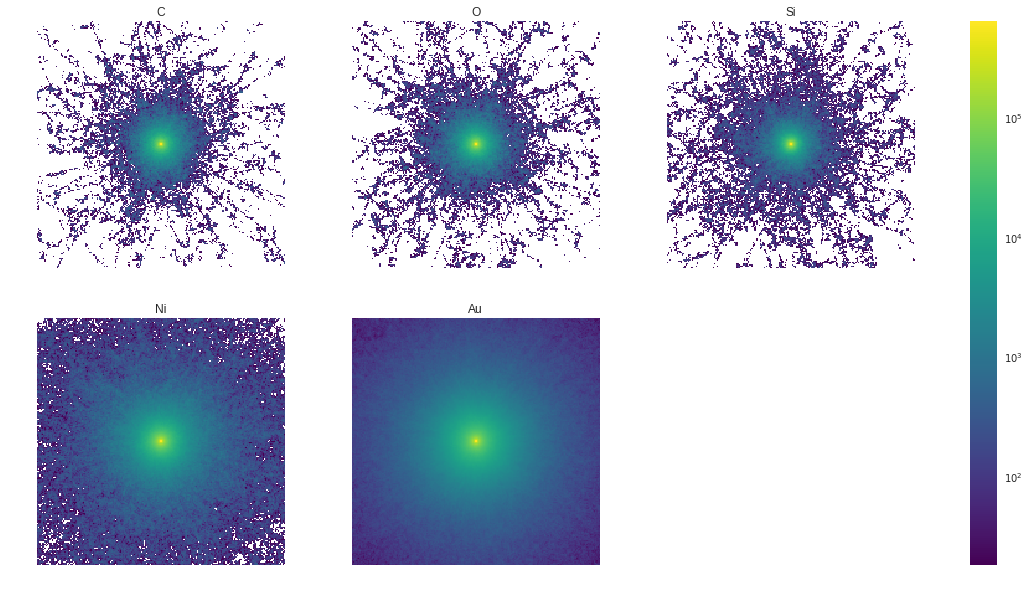

In [31]:
# Using Log color scale
limits = [[-100, 100], [-100, 100]]

fig, axes = plt.subplots(2, 3)
for ax, ion in zip(axes.flat, sorted(data, key=sort_by_mass)):
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (1, 2), limits, norm)
    ax.set_title(ion)
    ax.axis('off')
fig.delaxes(axes[1][2])
fig.colorbar(im, ax=axes.ravel().tolist())
fig.set_size_inches(20, 10)
fig.savefig('../images/radial-heatmap-log-nolabel.png', transparent=False, dpi=300)

/home/costrouc/dev/materials/yanwen-SiC/venv/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


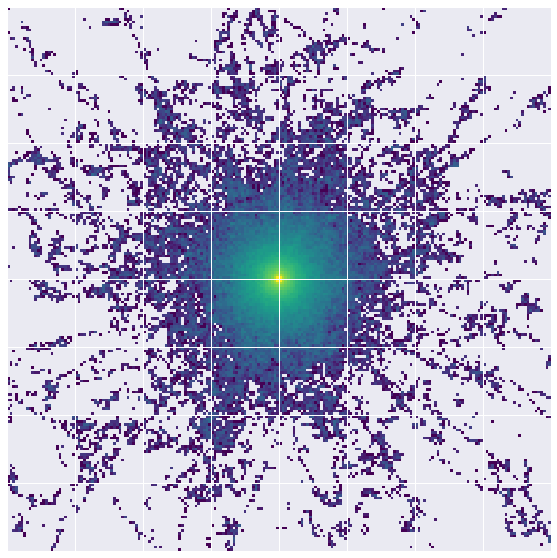

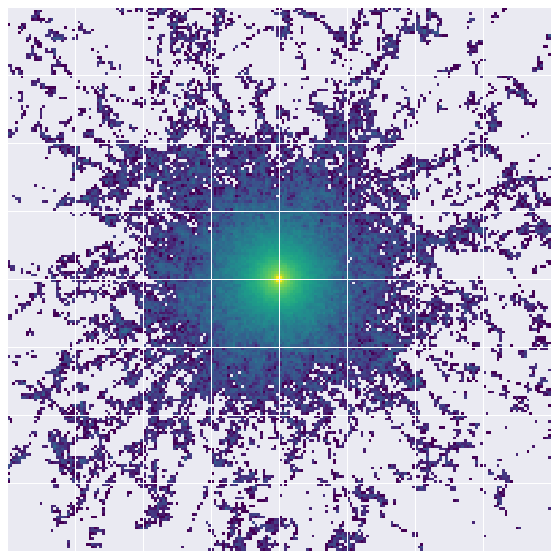

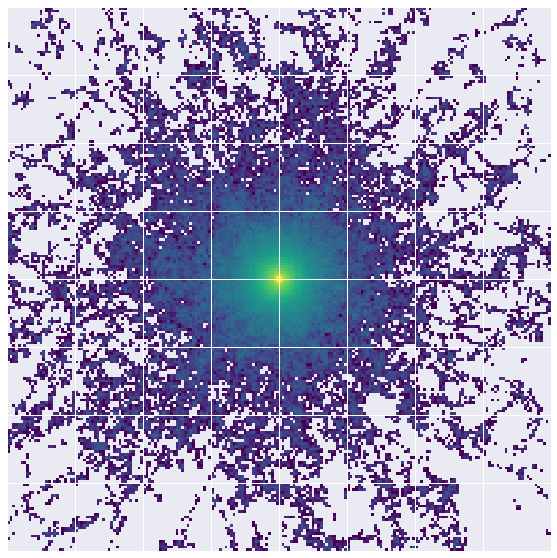

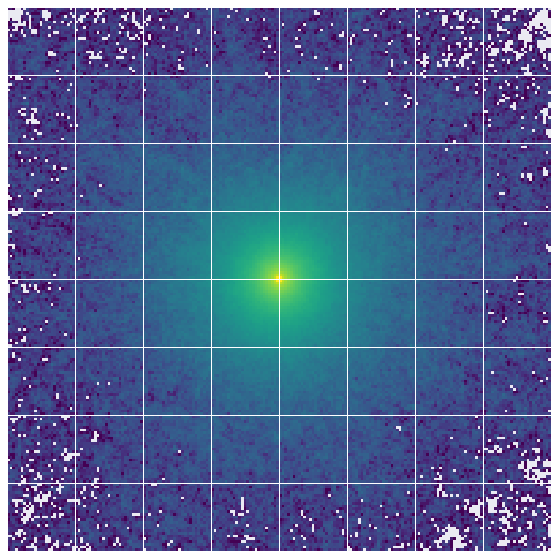

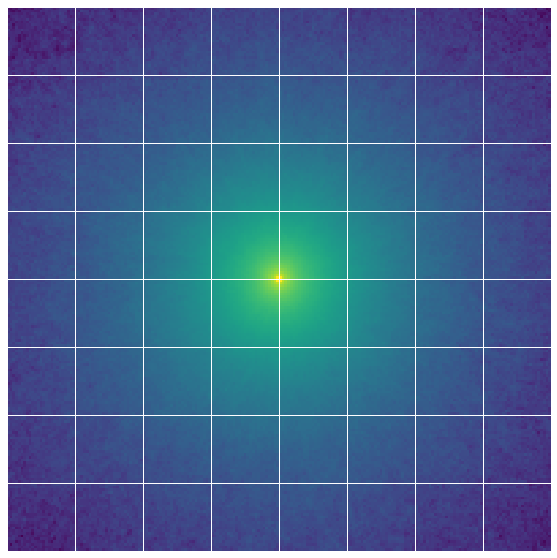

In [32]:
# Using Log color scale - several images
limits = [[-100, 100], [-100, 100]]

for ion in sorted(data, key=sort_by_mass):
    fig, ax = plt.subplots()
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (1, 2), limits, norm)
    # ax.set_title(ion)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fig.set_size_inches(10, 10)
    fig.savefig('../images/radial-heatmap-log-nolabel-%s.png' % ion, transparent=False, dpi=300)

0 C
1 O
2 Si
3 Ni
4 Au


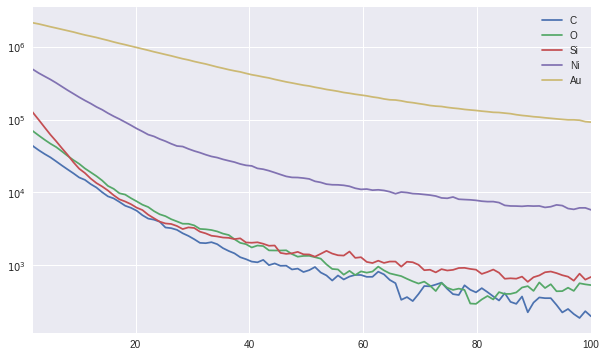

In [36]:
# Very small 100 nm (to more clearly show trend)
maximum = 100

fig, ax = plt.subplots()
for i, ion in enumerate(sorted(data, key=sort_by_mass)):
    print(i, ion)
    radius = np.linalg.norm(data[ion]['collisions'][:, 1:], axis=1)
    plot_radial_distribution_hist(ax, radius, maximum, ion)
# ax.set_title('Histogram Radial Distribution (yz) - %.2f [nm]' % maximum)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(2, maximum)
# ax.set_ylim(0, 60000)
ax.legend()
fig.set_size_inches(10, 6)
fig.savefig('../images/radial-hist.png', transparent=False, dpi=300)

In [8]:
maximum = 100

for i, ion in enumerate(sorted(data, key=sort_by_mass)):
    print(i, ion)
    radius = np.linalg.norm(data[ion]['collisions'][:, 1:], axis=1)
    density, edges = np.histogram(radius, bins=1000, density=False, range=(1e-8, maximum))
    x = np.linspace(1e-8, maximum, len(density))
    with open('../data/collisions-%s.csv' % ion, 'w') as f:
        f.write('%s radial distance [nm], count [collisions/A^2]\n' % ion)
        for x,y in zip(x, density):
            f.write('{:3.2f},{}\n'.format(x, y))

0 C
1 O
2 Si
3 Ni
